In [1]:
# # EVALution 1.0
# Dataset containing Semantic Relations and Metadata, for Training and Evaluating Distributional Semantic Models
# The resource is freely available. If you use it, please cite the description paper:
# - Enrico Santus, Frances Yung, Alessandro Lenci, and Chu-Ren Huang. 2015. EVALution 1.0: An Evolving Semantic Dataset for Training and Evaluation of Distributional Semantic Models. Proceedings of the 4th Workshop on Linked Data in Linguistics, Beijing.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [3]:
# keras modules
import tensorflow as tf
# from keras.models import load_model

from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences

# from keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.models import save_model, load_model
# from tensorflow.keras.utils import plot_model
# import keras_tqdm
# from livelossplot.keras import PlotLossesCallback

/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sjnam/anacond

In [4]:
# custom layers from external files
from layers.embeddings import ElmoLayer
from layers.attention import AttentionLayer
from models.build_models import build_model_elmo, initialize_vars
from models.train_models import *
from utils.utils import *

In [5]:
# some option settings for Jupyter notebook and TF
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_colwidth', -1)
tf.logging.set_verbosity(tf.logging.ERROR)

# Import data 

In [6]:
# collum descriptions::
#  - first relatum: it is one of the relata in the file RELATA.txt
#  - relation: it can be one of the following relations: Antonym, Synonym, IsA (hypernymy), PartOf (meronymy), MemberOf (meronymy), MadeOf (meronymy), Entailment, HasA (possession), HasProperty (attribute). For the definition of these relations, please refer to: https://github.com/commonsense/conceptnet5/wiki/Relations.
#  - second relatum: it is one of the relata in the file RELATA.txt
#  - tags: this field contains a comma separated list of tags, with their frequency among the total number of annotators (e.g. "CULTURE_1/5,EVENT_4/5" stays for CULTURE was tagged by 1 subject on 5, while PLANT by 4 on 5). NOTE: The reliability of the tags is slow, as some subjects have tried to cheat; we suggest you to rely on tags that were judged at least twice.
#  - sentence: this field contains a sentence that paraphrases the relation; this sentence was used in the crowdsourcing task to assess the quality of the relation.
#  - distribution of votes: the next five columns are integers that represent the number of votes for each value, with reference to the sentence in the previous field: "strong disagreement" (the first one, value=1), "disagreement", "neutral", "agreement" and "strong agreement" (the last one, value=5).
#  - agreement between subjects as reported by Crowdflower.
#  - number of subjects who voted the agreement with the sentence.
#  - average score (in the range between 1="strongly disagree" and 5="strongly agree").
#  - variance among the votes.
#  - average score minus the variance.
#  - source from which the pair was extracted.
#  - score in the source, if available.
eval_colnames = [
    "relata1",
    "relation",
    "relata2",
    "tags",
    "sentence",
    "votes_sc_1",
    "votes_sc_2",
    "votes_sc_3",
    "votes_sc_4",
    "votes_sc_5",
    "votes_agreement",
    "votes_no_agree",
    "votes_avg_score",
    "votes_var_score",
    "votes_avg_var_diff",
    "pair_source_name",
    "pair_source_score"
]

In [7]:
df_eval = pd.read_table("dataset/EVALution_1.0/RELATIONS.txt", sep="\t", header=None, names=eval_colnames, index_col=False)

/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.


In [8]:
df_eval['sentence'] = df_eval['sentence'].str.lower()

In [9]:
df_eval.head(10)

,relata1,relation,relata2,tags,sentence,votes_sc_1,votes_sc_2,votes_sc_3,votes_sc_4,votes_sc_5,votes_agreement,votes_no_agree,votes_avg_score,votes_var_score,votes_avg_var_diff,pair_source_name,pair_source_score
0,abstract,Antonym,concrete,"OBJECT_3/5,EMOTION_2/5,EVENT_2/5,RELATIONSHIP_1/5",abstract can be used as the opposite of concrete,0,0,0,3,2,0.912340,5,4.400000,0.300000,4.100000,wordnet/4.0,score
1,accident,Antonym,plan,"CULTURE_1/5,EVENT_4/5",accident can be used as the opposite of plan,0,0,0,12,26,0.953509,38,4.684211,0.221906,4.462304,verbosity,0.0445190226130131
2,accident,Antonym,purpose,EVENT_5/5,accident can be used as the opposite of purpose,0,0,0,3,2,0.913917,5,4.400000,0.300000,4.100000,verbosity,0.13952094877868304
3,accident,Synonym,event,EVENT_5/5,accident can be used with the same meaning of event,0,0,1,3,1,0.935375,5,4.000000,0.500000,3.500000,wiktionary/de/en,1.0
4,accident,IsA,error,"EVENT_4/5,RELATIONSHIP_1/5",accident is a kind of error,0,0,0,2,3,0.911600,5,4.600000,0.300000,4.300000,conceptnet/4/en,1.5849625007211563
5,accident,IsA,happen,EVENT_5/5,accident is a kind of happen,0,0,0,2,3,0.965458,5,4.600000,0.300000,4.300000,wordnet/3.0,1.5849625007211563
6,accident,IsA,mistake,"RELATIONSHIP_1/60,NATURE_1/60,FOOD_1/60,COMMUNICATION_2/60,OBJECT_3/60,CULTURE_2/60,EVENT_57/60",accident is a kind of mistake,0,0,0,2,3,0.954483,5,4.600000,0.300000,4.300000,conceptnet/4/en,1.5849625007211563
7,account,Synonym,record,"OBJECT_2/5,CULTURE_1/5,EVENT_2/5,BUSINESS_2/5",account can be used with the same meaning of record,0,0,0,2,3,0.908725,5,4.600000,0.300000,4.300000,wiktionary/de/en,1.0
8,account,Synonym,report,"EVENT_3/5,BUSINESS_2/5,NATURE_1/5",account can be used with the same meaning of report,0,0,0,2,3,0.967600,5,4.600000,0.300000,4.300000,wiktionary/de/en,1.0
9,account,Synonym,score,"OBJECT_2/6,EVENT_6/6,BUSINESS_1/6,NATURE_1/6",account can be used with the same meaning of score,0,1,0,2,2,0.962425,5,4.000000,1.500000,2.500000,wiktionary/de/en,1.0


In [10]:
df_eval.shape

(7492, 17)

In [11]:
df_eval['relation'].value_counts()

IsA            1880
Antonym        1600
HasProperty    1297
Synonym        1086
PartOf         654 
HasA           544 
MadeOf         317 
Entails        82  
MemberOf       32  
Name: relation, dtype: int64

In [12]:
# maximum sentence length
max([len(sent.split()) for sent in df_eval['sentence']])

10

# Process input data

## target word and sentence inputs 

In [13]:
tt1 = ["this", 'is', 'a', 'test', 'sentence']
tt2 = ['is', 'a']
tt_ret = []
for x in tt2:
    for i, k in enumerate(tt1):
        if(x==k):
            tt_ret.append(i)
tt_ret

[1, 2]

In [14]:
[x.lower() for x in "test_this".split("_")]

['test', 'this']

In [15]:
MAX_SEQ_LEN = 30

In [16]:
sentences_notarg = proc_sentences_EVALution(df_eval, 'sentence', 'relata1', 'relata2', 'relation', 
                                            False, MAX_SEQ_LEN, RELATIONAL_CUE_TOKENS)
sentences_wttarg = proc_sentences_EVALution(df_eval, 'sentence', 'relata1', 'relata2', 'relation', 
                                            True, MAX_SEQ_LEN, RELATIONAL_CUE_TOKENS)

In [17]:
sentences_notarg
# [sent[:10] for sent in sentences_notarg]

[array([9, 9, 9, ..., 7, 9, 6]),
 array([['<UNK>', 'can', 'be', ..., '', '', ''],
        ['<UNK>', 'can', 'be', ..., '', '', ''],
        ['<UNK>', 'can', 'be', ..., '', '', ''],
        ...,
        ['<UNK>', 'can', 'have', ..., '', '', ''],
        ['<UNK>', 'can', 'be', ..., '', '', ''],
        ['<UNK>', 'is', 'a', ..., '', '', '']], dtype=object),
 array([[0, 1, 1, ..., 0, 0, 0],
        [0, 1, 1, ..., 0, 0, 0],
        [0, 1, 1, ..., 0, 0, 0],
        ...,
        [0, 1, 1, ..., 0, 0, 0],
        [0, 1, 1, ..., 0, 0, 0],
        [0, 1, 1, ..., 0, 0, 0]]),
 array([[1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 arra

In [18]:
[sent[7] for sent in sentences_notarg]

[10, array(['<UNK>', 'can', 'be', 'used', 'with', 'the', 'same', 'meaning',
        'of', 'record', '', '', '', '', '', '', '', '', '', '', '', '', '',
        '', '', '', '', '', '', ''], dtype=object), array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])]

In [19]:
sentences_bert = proc_sentences_dscovar(df_eval, 'sentence', 'relata1', 'bert')

In [20]:
sentences_bert

[array(['abstract', 'accident', 'accident', ..., 'you', 'young', 'zero'],
       dtype='<U18'),
 array(['abstract can be used as the opposite of concrete',
        'accident can be used as the opposite of plan',
        'accident can be used as the opposite of purpose', ...,
        'you can have or can contain feel',
        'young can be used as the opposite of mature',
        'zero is a kind of number'], dtype='<U64')]

In [21]:
tokenizer = create_tokenizer_from_hub_module()
sentences_bert_examples = convert_text_to_examples(sentences_bert[0], sentences_bert[1], df_eval['votes_avg_score'])
sentences_bert_input = convert_examples_to_features(tokenizer, sentences_bert_examples, False, MAX_SEQ_LEN)
sentences_bert_input

(array([[ 103, 1169, 1129, ...,    0,    0,    0],
        [ 103, 1169, 1129, ...,    0,    0,    0],
        [ 103, 1169, 1129, ...,    0,    0,    0],
        ...,
        [ 103, 1169, 1138, ...,    0,    0,    0],
        [ 103, 1169, 1129, ...,    0,    0,    0],
        [ 103, 1110,  170, ...,    0,    0,    0]]),
 array([[0, 1, 1, ..., 0, 0, 0],
        [0, 1, 1, ..., 0, 0, 0],
        [0, 1, 1, ..., 0, 0, 0],
        ...,
        [0, 1, 1, ..., 0, 0, 0],
        [0, 1, 1, ..., 0, 0, 0],
        [0, 1, 1, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]]),
 array([[4.4       ],
        [4.6842105

# Attention results scoring strategy

- processing the input
    - consider relata1 as the target word
    - sentence as a context
    - see if the model pays more attention to relata2
    - vice versa: this can control the target word location (beginning (relata1) or end (relata2) of the context sentence)
- scoring
    - (assuming relata1 is the target word)
    - criterion 1: does the model pays more attention to relata2?
    - criterion 2: does the model pays more attention to relational cues? 
        - e.g., abstract can be used as the *opposite* of concrete
    - sum the rankings 

# Model output 

In [22]:
K.clear_session()
sess = tf.Session()

# model_elmo_notune_wtattn = build_model_elmo(MAX_SEQ_LEN, False, True,  False)
# model_elmo_notune_noattn = build_model_elmo(MAX_SEQ_LEN, False, False, False)
model_elmo_fntune_wtattn_1emb = build_model_elmo(MAX_SEQ_LEN, True, True,  False, lr=1e-3)
model_elmo_fntune_wtattn_2emb = build_model_elmo(MAX_SEQ_LEN, True, True, True, lr=1e-3)
model_bert_fntune_wtattn_1emb = build_model_bert(MAX_SEQ_LEN, True, True,  False, lr=3e-5)
model_bert_fntune_wtattn_2emb = build_model_bert(MAX_SEQ_LEN, True, True, True, lr=1e-5)

initialize_vars(sess)

1024
1024
1024


In [23]:
model_elmo_fntune_wtattn_1emb.load_weights('./model_weights/finetune/elmo/1emb/model_elmo_notarg_wtattn_bws_full_i5_b16_lr1e-04.tf')
model_elmo_fntune_wtattn_2emb.load_weights('./model_weights/finetune/elmo/2emb/model_elmo_notarg_wtattn_bws_full_i8_b16_lr1e-04.tf')
model_bert_fntune_wtattn_1emb.load_weights('./model_weights/finetune/bert/1emb/model_bert_notarg_wtattn_bws_full_i8_b16_lr3e-05.tf')
model_bert_fntune_wtattn_2emb.load_weights('./model_weights/finetune/bert/2emb/model_bert_notarg_wtattn_bws_full_i8_b16_lr1e-05.tf')

In [24]:
model_elmo_fntune_wtattn_1emb.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_sent_len (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_sentence (InputLayer)     [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 30)]         0                                            
__________________________________________________________________________________________________
elmo_sent_raw (ElmoLayer)       (None, None, 1024)   187201700   input_sent_len[0][0]             
                                                                 input_sentence[0][0]         

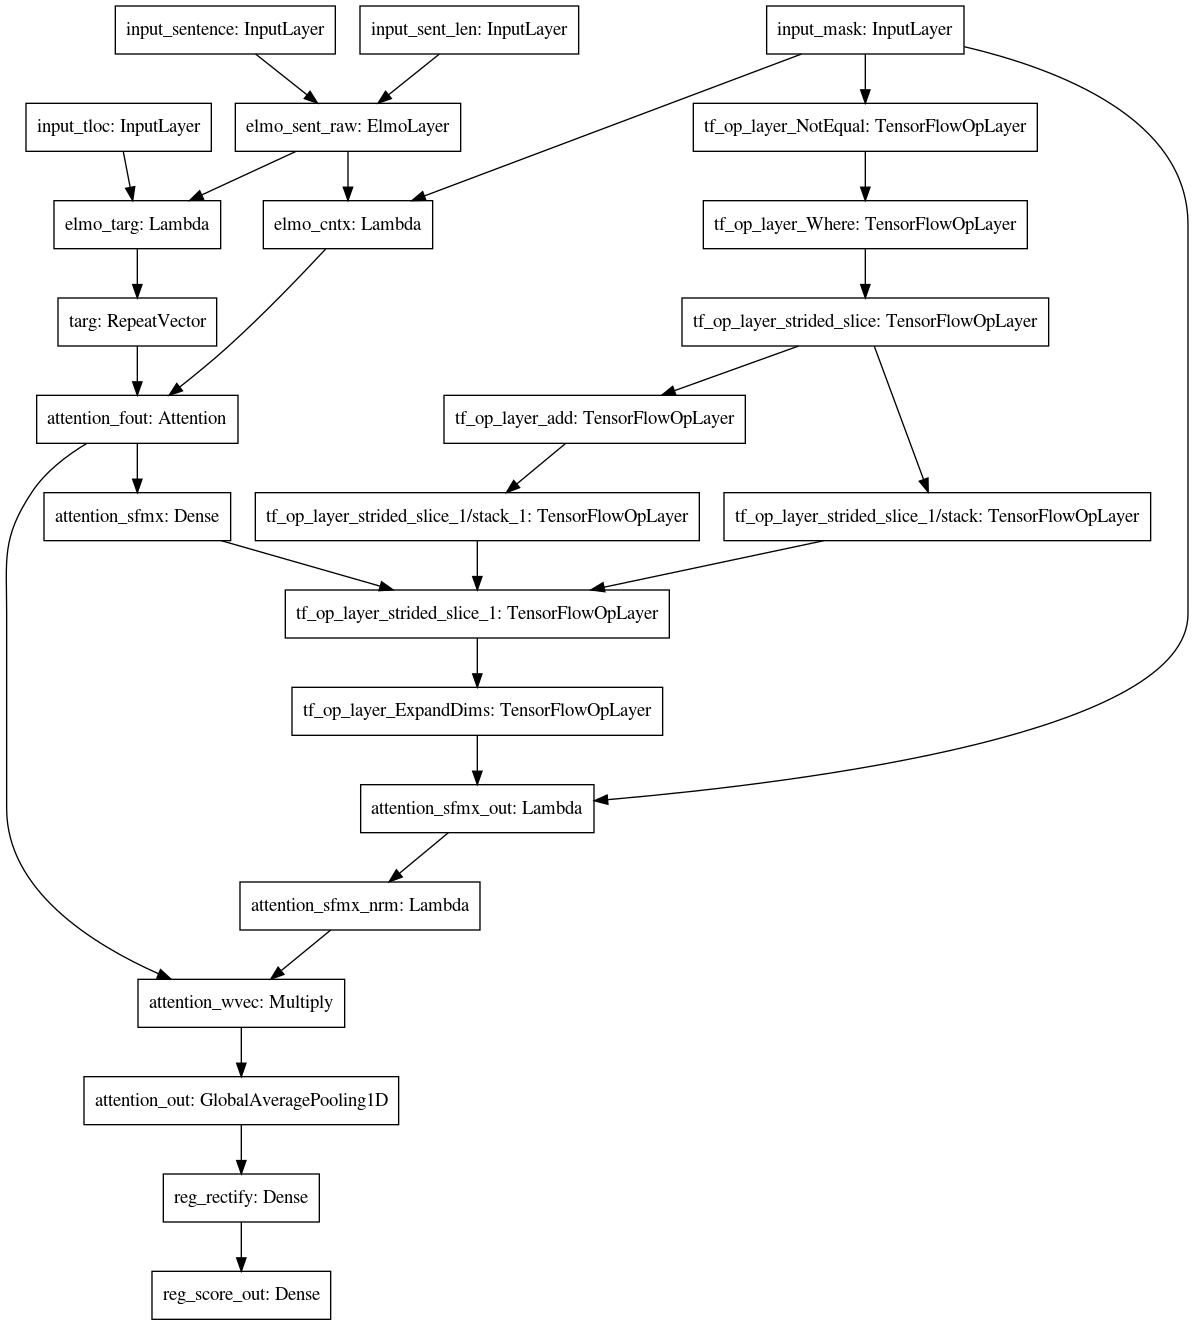

In [25]:
from tensorflow.keras.utils import plot_model
plot_model(model_elmo_fntune_wtattn_1emb)

In [26]:
model_elmo_fntune_attn_1emb = Model(model_elmo_fntune_wtattn_1emb.inputs, model_elmo_fntune_wtattn_1emb.get_layer("attention_sfmx_nrm").output)
model_elmo_fntune_attn_2emb = Model(model_elmo_fntune_wtattn_2emb.inputs, model_elmo_fntune_wtattn_2emb.get_layer("attention_sfmx_nrm").output)
model_bert_fntune_attn_1emb = Model(model_bert_fntune_wtattn_1emb.inputs, model_bert_fntune_wtattn_1emb.get_layer("attention_sfmx_nrm").output)
model_bert_fntune_attn_2emb = Model(model_bert_fntune_wtattn_2emb.inputs, model_bert_fntune_wtattn_2emb.get_layer("attention_sfmx_nrm").output)

In [27]:
elmo_fntune_attn_pred_1emb = np.transpose(model_elmo_fntune_attn_1emb.predict(sentences_notarg), axes=[0,2,1])[:, 0]
elmo_fntune_attn_pred_2emb = np.transpose(model_elmo_fntune_attn_2emb.predict(sentences_wttarg), axes=[0,2,1])[:, 0]
bert_fntune_attn_pred_1emb = np.transpose(model_bert_fntune_attn_1emb.predict(sentences_bert_input), axes=[0,2,1])[:, 0]
bert_fntune_attn_pred_2emb = np.transpose(model_bert_fntune_attn_2emb.predict(sentences_bert_input), axes=[0,2,1])[:, 0]

In [28]:
elmo_fntune_attn_pred_2emb[:2]

array([[0.02965284, 0.12026321, 0.08281168, 0.07767481, 0.21518163,
        0.06628642, 0.15360318, 0.1364435 , 0.11808267, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.04602183, 0.10450704, 0.10308171, 0.09159443, 0.14552256,
        0.05993407, 0.11106732, 0.29321155, 0.04505945, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]],
      dtype=float32)

In [29]:
elmo_fntune_attn_pred_1emb[7], elmo_fntune_attn_pred_2emb[7]

(array([0.        , 0.15032548, 0.15411879, 0.25679603, 0.09195416,
        0.09181873, 0.04582194, 0.0609627 , 0.02441469, 0.12378743,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       dtype=float32),
 array([0.0097184 , 0.07987139, 0.07447877, 0.06101103, 0.32442522,
        0.10101136, 0.10898655, 0.15513684, 0.05236709, 0.03299338,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       dtype=float32))

In [30]:
bert_fntune_attn_pred_1emb[7], bert_fntune_attn_pred_2emb[7]# * sentences_notarg[2][7]

(array([0.        , 0.06830554, 0.07866738, 0.05957297, 0.34406558,
        0.08619511, 0.09437101, 0.04694412, 0.06155021, 0.16032805,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       dtype=float32),
 array([0.        , 0.04107545, 0.21735585, 0.02778581, 0.02225405,
        0.30327392, 0.0233975 , 0.07123913, 0.24637459, 0.04724367,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       dtype=float32))

Text(0.5,1,'bert_finetune_2emb')

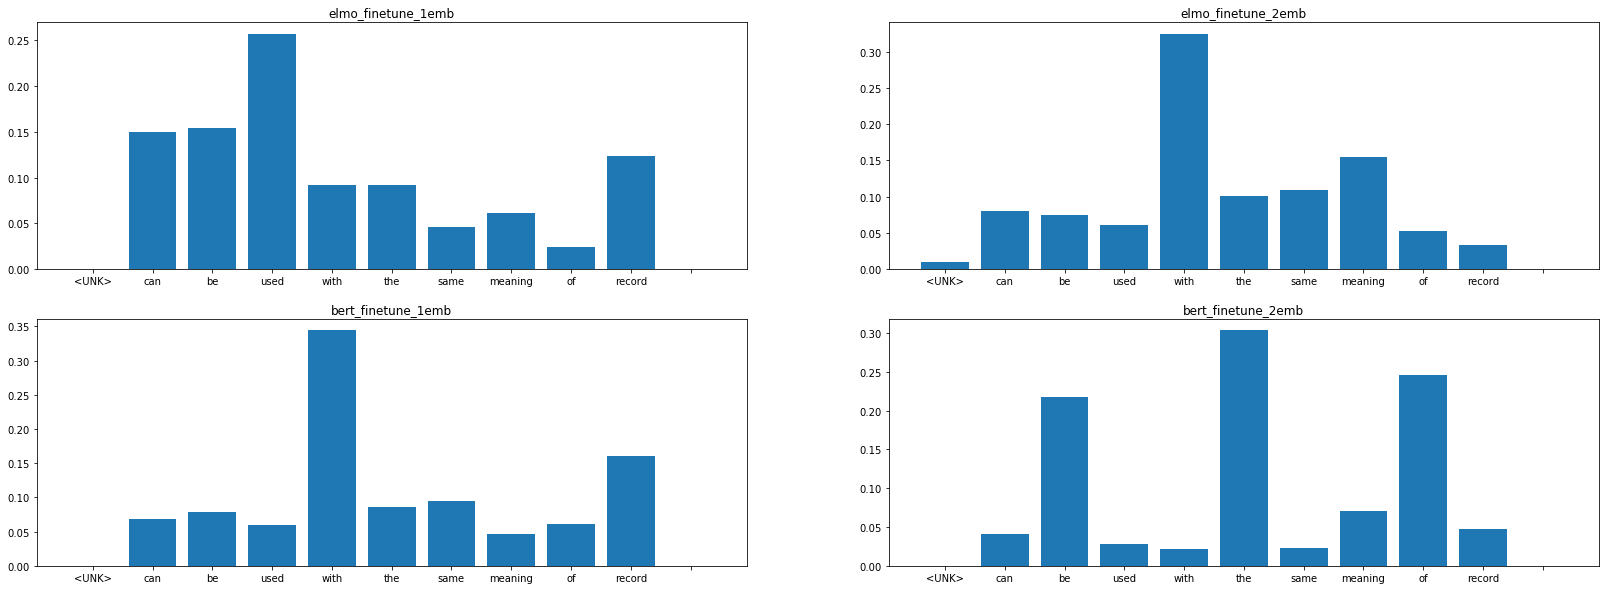

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(28, 10))

axes[0][0].bar(x=sentences_notarg[1][7], height=elmo_fntune_attn_pred_1emb[7]) #min_max_sc(elmo_fntune_attn_pred_1emb[7] * sentences_notarg[2][7]))
axes[0][1].bar(x=sentences_notarg[1][7], height=elmo_fntune_attn_pred_2emb[7]) #min_max_sc(elmo_fntune_attn_pred_2emb[7] * sentences_notarg[2][7]))
axes[1][0].bar(x=sentences_notarg[1][7], height=bert_fntune_attn_pred_1emb[7]) #min_max_sc(bert_fntune_attn_pred_1emb[7] * sentences_notarg[2][7]))
axes[1][1].bar(x=sentences_notarg[1][7], height=bert_fntune_attn_pred_2emb[7]) #min_max_sc(bert_fntune_attn_pred_2emb[7] * sentences_notarg[2][7]))

axes[0][0].set_title("elmo_finetune_1emb")
axes[0][1].set_title("elmo_finetune_2emb")
axes[1][0].set_title("bert_finetune_1emb")
axes[1][1].set_title("bert_finetune_2emb")


In [32]:
print("target_pair_loc:", np.where(sentences_notarg[4][7])[0][0], 
      "relation_cue_loc:", np.where(sentences_notarg[5][7])[0][0])

target_pair_loc: 9 relation_cue_loc: 6


In [33]:
[attention_ranks(elmo_fntune_attn_pred_1emb[7], sentences_notarg[2][7], sentences_notarg[4][7]), attention_ranks(elmo_fntune_attn_pred_1emb[7], sentences_notarg[2][7], sentences_notarg[5][7]),
 attention_ranks(elmo_fntune_attn_pred_2emb[7], sentences_notarg[2][7], sentences_notarg[4][7]), attention_ranks(elmo_fntune_attn_pred_2emb[7], sentences_notarg[2][7], sentences_notarg[5][7]),
 attention_ranks(bert_fntune_attn_pred_1emb[7], sentences_notarg[2][7], sentences_notarg[4][7]), attention_ranks(bert_fntune_attn_pred_1emb[7], sentences_notarg[2][7], sentences_notarg[5][7]),
 attention_ranks(bert_fntune_attn_pred_2emb[7], sentences_notarg[2][7], sentences_notarg[4][7]), attention_ranks(bert_fntune_attn_pred_2emb[7], sentences_notarg[2][7], sentences_notarg[5][7]),
]

[array([3]),
 array([7, 6]),
 array([8]),
 array([2, 1]),
 array([1]),
 array([2, 8]),
 array([4]),
 array([7, 3])]

In [34]:
[attention_scores(elmo_fntune_attn_pred_1emb[7], sentences_notarg[0][7], sentences_notarg[2][7], sentences_notarg[4][7], sentences_notarg[5][7]),
 attention_scores(elmo_fntune_attn_pred_2emb[7], sentences_notarg[0][7], sentences_notarg[2][7], sentences_notarg[4][7], sentences_notarg[5][7]),
 attention_scores(bert_fntune_attn_pred_1emb[7], sentences_notarg[0][7], sentences_notarg[2][7], sentences_notarg[4][7], sentences_notarg[5][7]),
 attention_scores(bert_fntune_attn_pred_2emb[7], sentences_notarg[0][7], sentences_notarg[2][7], sentences_notarg[4][7], sentences_notarg[5][7])]

[array([0.7 , 0.35]),
 array([0.2 , 0.85]),
 array([0.9, 0.5]),
 array([0.6, 0.5])]

In [35]:
elmo_fntune_1emb_attscore = np.array([attention_scores(elmo_fntune_attn_pred_1emb[i], sentences_notarg[0][i], sentences_notarg[2][i], sentences_notarg[4][i], sentences_notarg[5][i]) for i in range(df_eval.shape[0])])
elmo_fntune_2emb_attscore = np.array([attention_scores(elmo_fntune_attn_pred_2emb[i], sentences_notarg[0][i], sentences_notarg[2][i], sentences_notarg[4][i], sentences_notarg[5][i]) for i in range(df_eval.shape[0])])
bert_fntune_1emb_attscore = np.array([attention_scores(bert_fntune_attn_pred_1emb[i], sentences_notarg[0][i], sentences_notarg[2][i], sentences_notarg[4][i], sentences_notarg[5][i]) for i in range(df_eval.shape[0])])
bert_fntune_2emb_attscore = np.array([attention_scores(bert_fntune_attn_pred_2emb[i], sentences_notarg[0][i], sentences_notarg[2][i], sentences_notarg[4][i], sentences_notarg[5][i]) for i in range(df_eval.shape[0])])


In [36]:
df_eval['elmo_fntune_1emb_attscore_pair'] = elmo_fntune_1emb_attscore[:,0]
df_eval['elmo_fntune_1emb_attscore_rcue'] = elmo_fntune_1emb_attscore[:,1]
df_eval['elmo_fntune_2emb_attscore_pair'] = elmo_fntune_2emb_attscore[:,0]
df_eval['elmo_fntune_2emb_attscore_rcue'] = elmo_fntune_2emb_attscore[:,1]
df_eval['bert_fntune_1emb_attscore_pair'] = bert_fntune_1emb_attscore[:,0]
df_eval['bert_fntune_1emb_attscore_rcue'] = bert_fntune_1emb_attscore[:,1]
df_eval['bert_fntune_2emb_attscore_pair'] = bert_fntune_2emb_attscore[:,0]
df_eval['bert_fntune_2emb_attscore_rcue'] = bert_fntune_2emb_attscore[:,1]
df_eval['elmo_fntune_1emb_attscore_sum'] = df_eval['elmo_fntune_1emb_attscore_pair']+df_eval['elmo_fntune_1emb_attscore_rcue']
df_eval['elmo_fntune_2emb_attscore_sum'] = df_eval['elmo_fntune_2emb_attscore_pair']+df_eval['elmo_fntune_2emb_attscore_rcue']
df_eval['bert_fntune_1emb_attscore_sum'] = df_eval['bert_fntune_1emb_attscore_pair']+df_eval['bert_fntune_1emb_attscore_rcue']
df_eval['bert_fntune_2emb_attscore_sum'] = df_eval['bert_fntune_2emb_attscore_pair']+df_eval['bert_fntune_2emb_attscore_rcue']

- Score: pair < rcue
    - if context does not include the target word
        - Antonym, HasProperty, Synonym
    - if context does include the target word
        - Entails, MadeOf
- Score: no target < with target
    - target-pair word
        - IsA
    - relational cue
        - MadeOf

In [37]:
tt = df_eval.groupby('relation').apply(lambda df:df[['elmo_fntune_1emb_attscore_pair', 'elmo_fntune_1emb_attscore_rcue', 'elmo_fntune_1emb_attscore_sum',
                                                     'elmo_fntune_2emb_attscore_pair', 'elmo_fntune_2emb_attscore_rcue', 'elmo_fntune_2emb_attscore_sum',
                                                     'bert_fntune_1emb_attscore_pair', 'bert_fntune_1emb_attscore_rcue', 'bert_fntune_1emb_attscore_sum',
                                                     'bert_fntune_2emb_attscore_pair', 'bert_fntune_2emb_attscore_rcue', 'bert_fntune_2emb_attscore_sum']].mean())
# tt.loc['sum'] = tt.sum(axis=0)
tt.loc['overall avg.'] = [df_eval['elmo_fntune_1emb_attscore_pair'].mean(), df_eval['elmo_fntune_1emb_attscore_rcue'].mean(), df_eval['elmo_fntune_1emb_attscore_sum'].mean(),
                          df_eval['elmo_fntune_2emb_attscore_pair'].mean(), df_eval['elmo_fntune_2emb_attscore_rcue'].mean(), df_eval['elmo_fntune_2emb_attscore_sum'].mean(),
                          df_eval['bert_fntune_1emb_attscore_pair'].mean(), df_eval['bert_fntune_1emb_attscore_rcue'].mean(), df_eval['bert_fntune_1emb_attscore_sum'].mean(),
                          df_eval['bert_fntune_2emb_attscore_pair'].mean(), df_eval['bert_fntune_2emb_attscore_rcue'].mean(), df_eval['bert_fntune_2emb_attscore_sum'].mean(),]
tt.round(3)

,elmo_fntune_1emb_attscore_pair,elmo_fntune_1emb_attscore_rcue,elmo_fntune_1emb_attscore_sum,elmo_fntune_2emb_attscore_pair,elmo_fntune_2emb_attscore_rcue,elmo_fntune_2emb_attscore_sum,bert_fntune_1emb_attscore_pair,bert_fntune_1emb_attscore_rcue,bert_fntune_1emb_attscore_sum,bert_fntune_2emb_attscore_pair,bert_fntune_2emb_attscore_rcue,bert_fntune_2emb_attscore_sum
relation,,,,,,,,,,,,
Antonym,0.228,0.336,0.564,0.572,0.491,1.063,0.593,0.772,1.366,0.947,0.350,1.298
Entails,0.493,0.601,1.094,0.722,0.699,1.421,0.635,0.582,1.217,0.829,0.704,1.532
HasA,0.290,0.727,1.017,0.493,0.666,1.159,0.727,0.507,1.234,0.567,0.924,1.491
HasProperty,0.495,0.995,1.489,0.648,0.493,1.141,0.667,0.694,1.361,0.902,0.355,1.257
IsA,0.530,0.992,1.522,0.695,0.505,1.201,0.797,0.589,1.386,0.972,0.344,1.316
MadeOf,0.399,0.685,1.084,0.882,0.722,1.604,0.961,0.664,1.626,0.578,0.991,1.569
MemberOf,0.500,0.995,1.495,0.589,0.510,1.099,0.729,0.370,1.099,0.995,0.344,1.339
PartOf,0.402,0.700,1.102,0.884,0.674,1.558,0.976,0.671,1.647,0.579,0.977,1.556
Synonym,0.865,0.357,1.222,0.398,0.645,1.043,0.873,0.447,1.321,0.502,0.499,1.001


Santus et al., 2015: The list of relationship and example relational cues
<img src="dataset/EVALution_1.0/santus_et_al__hearst.png">

In [38]:
# elmo finetune: 1emb vs 2emb
{"pair":(df_eval['elmo_fntune_1emb_attscore_pair'].mean(), df_eval['elmo_fntune_2emb_attscore_pair'].mean(), ttest_ind(df_eval['elmo_fntune_1emb_attscore_pair'], df_eval['elmo_fntune_2emb_attscore_pair'])),
 "rcue":(df_eval['elmo_fntune_1emb_attscore_rcue'].mean(), df_eval['elmo_fntune_2emb_attscore_rcue'].mean(), ttest_ind(df_eval['elmo_fntune_1emb_attscore_rcue'], df_eval['elmo_fntune_2emb_attscore_rcue'])),
 "sum": (df_eval['elmo_fntune_1emb_attscore_sum'].mean(),   df_eval['elmo_fntune_2emb_attscore_sum'].mean(),  ttest_ind(df_eval['elmo_fntune_1emb_attscore_sum'], df_eval['elmo_fntune_2emb_attscore_sum']))}

{'pair': (0.47319473062432227,
  0.6272023411472156,
  Ttest_indResult(statistic=-37.805271904344046, pvalue=8.189518422241532e-299)),
 'rcue': (0.6983055888121291,
  0.5580524420854106,
  Ttest_indResult(statistic=33.032503715818976, pvalue=4.890484954754885e-231)),
 'sum': (1.1715003194364513,
  1.1852547832326263,
  Ttest_indResult(statistic=-2.4045652495967045, pvalue=0.016203772010561175))}

In [39]:
# bert finetune: 1emb vs 2emb
{"pair":(df_eval['bert_fntune_1emb_attscore_pair'].mean(), df_eval['bert_fntune_2emb_attscore_pair'].mean(), ttest_ind(df_eval['bert_fntune_1emb_attscore_pair'], df_eval['bert_fntune_2emb_attscore_pair'])),
 "rcue":(df_eval['bert_fntune_1emb_attscore_rcue'].mean(), df_eval['bert_fntune_2emb_attscore_rcue'].mean(), ttest_ind(df_eval['bert_fntune_1emb_attscore_rcue'], df_eval['bert_fntune_2emb_attscore_rcue'])),
 "sum": (df_eval['bert_fntune_1emb_attscore_sum'].mean(),  df_eval['bert_fntune_2emb_attscore_sum'].mean(),  ttest_ind(df_eval['bert_fntune_1emb_attscore_sum'],  df_eval['bert_fntune_2emb_attscore_sum']))}

{'pair': (0.7574834565399502,
  0.8047299486776595,
  Ttest_indResult(statistic=-12.746342675537154, pvalue=5.086593768360414e-37)),
 'rcue': (0.6293828247645653,
  0.49844328739817256,
  Ttest_indResult(statistic=36.73277076159263, pvalue=6.468741492900979e-283)),
 'sum': (1.3868662813045156,
  1.3031732360758324,
  Ttest_indResult(statistic=23.061655474451367, pvalue=1.1502564916134773e-115))}

In [40]:
# 1emb finetune: elmo vs bert
{"pair":(df_eval['elmo_fntune_1emb_attscore_pair'].mean(), df_eval['bert_fntune_1emb_attscore_pair'].mean(), ttest_ind(df_eval['elmo_fntune_1emb_attscore_pair'], df_eval['bert_fntune_1emb_attscore_pair'])),
 "rcue":(df_eval['elmo_fntune_1emb_attscore_rcue'].mean(), df_eval['bert_fntune_1emb_attscore_rcue'].mean(), ttest_ind(df_eval['elmo_fntune_1emb_attscore_rcue'], df_eval['bert_fntune_1emb_attscore_rcue'])),
 "sum" :(df_eval['elmo_fntune_1emb_attscore_sum'].mean(),  df_eval['bert_fntune_1emb_attscore_sum'].mean(),  ttest_ind(df_eval['elmo_fntune_1emb_attscore_sum'],  df_eval['bert_fntune_1emb_attscore_sum']))}

{'pair': (0.47319473062432227,
  0.7574834565399502,
  Ttest_indResult(statistic=-79.85842804274778, pvalue=0.0)),
 'rcue': (0.6983055888121291,
  0.6293828247645653,
  Ttest_indResult(statistic=17.359024580150425, pvalue=7.593321648429902e-67)),
 'sum': (1.1715003194364513,
  1.3868662813045156,
  Ttest_indResult(statistic=-41.89884390073213, pvalue=0.0))}

In [41]:
# 2emb finetune: elmo vs bert
{"pair":(df_eval['elmo_fntune_2emb_attscore_pair'].mean(), df_eval['bert_fntune_2emb_attscore_pair'].mean(), ttest_ind(df_eval['elmo_fntune_2emb_attscore_pair'], df_eval['bert_fntune_2emb_attscore_pair'])),
 "rcue":(df_eval['elmo_fntune_2emb_attscore_rcue'].mean(), df_eval['bert_fntune_2emb_attscore_rcue'].mean(), ttest_ind(df_eval['elmo_fntune_2emb_attscore_rcue'], df_eval['bert_fntune_2emb_attscore_rcue'])),
 "sum" :(df_eval['elmo_fntune_2emb_attscore_sum'].mean(),  df_eval['bert_fntune_2emb_attscore_sum'].mean(),  ttest_ind(df_eval['elmo_fntune_2emb_attscore_sum'],  df_eval['bert_fntune_2emb_attscore_sum']))}

{'pair': (0.6272023411472156,
  0.8047299486776595,
  Ttest_indResult(statistic=-42.242687943892975, pvalue=0.0)),
 'rcue': (0.5580524420854106,
  0.49844328739817256,
  Ttest_indResult(statistic=15.406318213838919, pvalue=3.792643694921283e-53)),
 'sum': (1.1852547832326263,
  1.3031732360758324,
  Ttest_indResult(statistic=-26.72425913246958, pvalue=9.637605143334927e-154))}